In [1]:
import umap
import torch
import pandas as pd
import numpy as np
from bertopic import BERTopic
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from colbert.modeling.checkpoint import Checkpoint
from colbert.infra import ColBERTConfig
import pandas as pd
from scipy.stats import chi2_contingency
import math
pd.set_option('display.max_colwidth',-1)

2024-09-11 15:55:14.539224: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-11 15:55:14.539243: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load data

In [2]:
#!unzip data/interim/stenos_cleaned_faction2022_topics.zip

In [3]:
df=pd.read_csv('data/interim/stenos_cleaned_faction2022_topics.csv')
df.shape

(465494, 27)

In [4]:
df.head()

,heading,speaker,link_video,link_steno,index_pk,index_snd,year,month,day,time,...,ntoks_splitted,doc_id,topic_id,topic_prob,Name,cluster_name,cluster_name_very_high,topic_reduce_outliers,Name_red_outliers,fation
0,10:00 Istungi rakendamine,Aseesimees Siim Kallas,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=0,https://stenogrammid.riigikogu.ee/201911191000,PKP-25040,SND-559399,2019,11,19,10:00,...,77,0,273.0,0.652444,273_kohaloleku_kontroll_arupärimisi_töönädala,istungjärgu_töönädala_arupärimisi_istungit_tere,palun_lugemine_juhtivkomisjoni_läbirääkimisi_kõnesoove,273.0,273_kohaloleku_kontroll_arupärimisi_töönädala,NaN
1,"1.\n 10:02 Eesti Keskerakonna fraktsiooni algatatud olulise tähtsusega riikliku küsimuse ""Maksusüsteem – kuidas edasi?"" arutelu",Aseesimees Siim Kallas,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=125,https://stenogrammid.riigikogu.ee/201911191000,PKP-25041,SND-559400,2019,11,19,10:02,...,80,1,1243.0,0.572646,1243_ettekanne_teostamisel_minutit_tegevusest,ettekanne_minutit_kuni_vastused_fraktsioonide,palun_lugemine_juhtivkomisjoni_läbirääkimisi_kõnesoove,1243.0,1243_ettekanne_teostamisel_minutit_tegevusest,NaN
2,"1.\n 10:02 Eesti Keskerakonna fraktsiooni algatatud olulise tähtsusega riikliku küsimuse ""Maksusüsteem – kuidas edasi?"" arutelu",Aseesimees Siim Kallas,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=125,https://stenogrammid.riigikogu.ee/201911191000,PKP-25041,SND-559400,2019,11,19,10:02,...,80,2,207.0,0.850651,207_ettekanne_sõnavõttudega_minutit_vastused,ettekanne_minutit_kuni_vastused_fraktsioonide,palun_lugemine_juhtivkomisjoni_läbirääkimisi_kõnesoove,207.0,207_ettekanne_sõnavõttudega_minutit_vastused,NaN
3,"1.\n 10:02 Eesti Keskerakonna fraktsiooni algatatud olulise tähtsusega riikliku küsimuse ""Maksusüsteem – kuidas edasi?"" arutelu",Aseesimees Siim Kallas,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=125,https://stenogrammid.riigikogu.ee/201911191000,PKP-25041,SND-559400,2019,11,19,10:02,...,75,3,139.0,0.818905,139_ammendumiseni_pikendada_kauem_kella,kella_ammendumiseni_pikendada_kauem_ni,palun_lugemine_juhtivkomisjoni_läbirääkimisi_kõnesoove,139.0,139_ammendumiseni_pikendada_kauem_kella,NaN
4,"1.\n 10:02 Eesti Keskerakonna fraktsiooni algatatud olulise tähtsusega riikliku küsimuse ""Maksusüsteem – kuidas edasi?"" arutelu",Kersti Sarapuu,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=238,https://stenogrammid.riigikogu.ee/201911191000,PKP-25041,SND-559401,2019,11,19,10:02,...,80,4,-1.0,0.000000,-1_ma_te_me_et,-1_ma_te_me_et,-1_ma_te_me_et,1461.0,1461_maksude_maksud_maksudega_mängita,Eesti Keskerakonna fraktsioon


In [5]:
df.columns

Index(['heading', 'speaker', 'link_video', 'link_steno', 'index_pk',
       'index_snd', 'year', 'month', 'day', 'time', 'seconds_from_start',
       'video_link_wo_time', 'text_wo_punct', 'date', 'koosseis', 'ntoks',
       'text_splitted', 'ntoks_splitted', 'doc_id', 'topic_id', 'topic_prob',
       'Name', 'cluster_name', 'cluster_name_very_high',
       'topic_reduce_outliers', 'Name_red_outliers', 'fation'],
      dtype='object')

In [6]:
df.text_splitted.nunique()

413761

In [7]:
df.shape

(465494, 27)

## Embed some texts

In [8]:
df_subset=df.iloc[-50000:,]

### BGE

In [9]:
model = SentenceTransformer('BAAI/bge-m3')
embeddings = model.encode(df_subset.text_splitted.tolist(), normalize_embeddings=True)

In [10]:
embeddings.shape

(50000, 1024)

### Cluster texts

In [11]:
import umap

# Reduce dimensions using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings = umap_reducer.fit_transform(embeddings)

In [12]:
import hdbscan

# Perform clustering using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, cluster_selection_epsilon=0.1)
labels = clusterer.fit_predict(reduced_embeddings)

# Print the cluster labels
print(labels)

[ 85 234 234 ... 234 234 234]


In [13]:
len(set(labels))

236

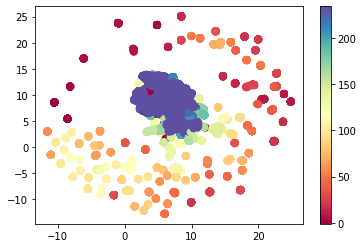

In [14]:
import matplotlib.pyplot as plt

# Plot UMAP-reduced data with clusters
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='Spectral', s=50)
plt.colorbar()
plt.show()

### E5

In [15]:
model_e5 = SentenceTransformer('intfloat/multilingual-e5-large')
embeddings_e5 = model_e5.encode(df_subset.text_splitted.tolist(), normalize_embeddings=True)

In [16]:
# Reduce dimensions using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings_e5 = umap_reducer.fit_transform(embeddings_e5)

In [17]:
# Perform clustering using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, cluster_selection_epsilon=0.1)
labels_e5 = clusterer.fit_predict(reduced_embeddings_e5)

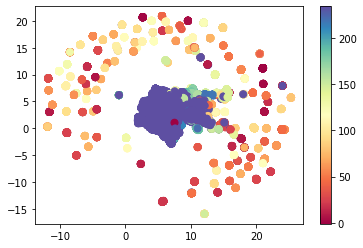

In [18]:
# Plot UMAP-reduced data with clusters
plt.scatter(reduced_embeddings_e5[:, 0], reduced_embeddings_e5[:, 1], c=labels, cmap='Spectral', s=50)
plt.colorbar()
plt.show()

## colbert

In [19]:
ckpt = Checkpoint("answerdotai/answerai-colbert-small-v1", colbert_config=ColBERTConfig())
embedded_query = ckpt.queryFromText(["Who dubs Howl's in English?"], bsize=16)

In [20]:
embs_colbert=ckpt.queryFromText(df_subset.text_splitted.tolist(), bsize=16)

In [21]:
embs_colbert_cls_pool=embs_colbert[:, 0, :]

In [22]:
embs_colbert_mean_pool=torch.mean(embs_colbert, dim=1) 

In [23]:
# Reduce dimensions using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings_colb_cls_pool = umap_reducer.fit_transform(embs_colbert_cls_pool.cpu())

In [24]:
# Perform clustering using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, cluster_selection_epsilon=0.1)
labels_colb_cls = clusterer.fit_predict(reduced_embeddings_colb_cls_pool)

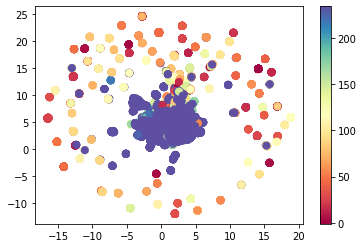

In [25]:
# Plot UMAP-reduced data with clusters
plt.scatter(reduced_embeddings_colb_cls_pool[:, 0], reduced_embeddings_colb_cls_pool[:, 1], c=labels, cmap='Spectral', s=50)
plt.colorbar()
plt.show()

In [26]:
# Reduce dimensions using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings_colb_mean_pool = umap_reducer.fit_transform(embs_colbert_mean_pool.cpu())

In [27]:
# Perform clustering using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, cluster_selection_epsilon=0.1)
labels_colb_mean = clusterer.fit_predict(reduced_embeddings_colb_mean_pool)

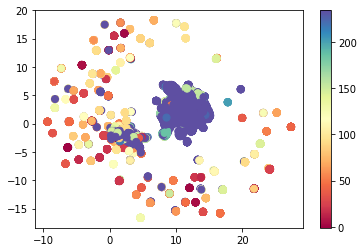

In [28]:
# Plot UMAP-reduced data with clusters
plt.scatter(reduced_embeddings_colb_mean_pool[:, 0], reduced_embeddings_colb_mean_pool[:, 1], c=labels, cmap='Spectral', s=50)
plt.colorbar()
plt.show()

## LaBSE

In [29]:
model_labse = SentenceTransformer('sentence-transformers/LaBSE')
embeddings_labse = model_labse.encode(df_subset.text_splitted.tolist())

In [30]:
# Reduce dimensions using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings_labse = umap_reducer.fit_transform(embeddings_labse)

In [31]:
# Perform clustering using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, cluster_selection_epsilon=0.1)
labels_labse = clusterer.fit_predict(reduced_embeddings_labse)

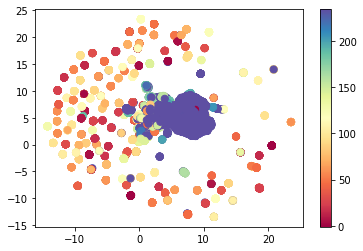

In [32]:
# Plot UMAP-reduced data with clusters
plt.scatter(reduced_embeddings_labse[:, 0], reduced_embeddings_labse[:, 1], c=labels, cmap='Spectral', s=50)
plt.colorbar()
plt.show()

## Add labels to data

In [33]:
df_subset['cluster_bge']=labels
df_subset['cluster_e5']=labels_e5
df_subset['cluster_colb_cls']=labels_colb_cls
df_subset['cluster_e5']=labels_colb_mean
df_subset['cluster_labse']=labels_labse

In [34]:
df_subset.cluster_bge.value_counts()

234    42053
144    455  
161    226  
45     214  
20     203  
      ...   
203    2    
6      2    
166    2    
209    2    
159    2    
Name: cluster_bge, Length: 236, dtype: int64

In [35]:
df_subset[df_subset.cluster_bge==249].text_splitted

Series([], Name: text_splitted, dtype: object)

In [36]:
df_subset[['cluster_name','cluster_bge','cluster_e5','cluster_labse','text_splitted']].sample(20)

,cluster_name,cluster_bge,cluster_e5,cluster_labse,text_splitted
464527,post_rahvastikuregistri_posti_elukoha_rahvastikuregistrisse,234,225,249,puudutab õiguslikku soo muutmist rahvastikuregistris saab aset leida pärast seda kui tervisekomisjoni otsuse alusel on läbi viidud vastav meditsiiniline protseduur siis kas selle uue soolise ebakõla kohta ma vaatan siin on öeldud et komisjoni otsuse alusel saab rahvastikuregistris hakata kandeid tegema ka ilma meditsiinilise protseduurita ehk tegelikult ideoloogilise valikuna
432371,-1_ma_te_me_et,234,225,249,aitäh teate ütlen täitsa ausalt minul on ka väga kurb meel et isamaal ei ole õiguskomisjonis liiget ma arvan et me kõik kurvastame selle üle eriti arvestades neid viimaste päevade menetlusi mis seal on olnud ühte sellist liiget kes seisab terve mõistuse ja normaalsuse eest oleks seal kindlasti juurde vaja ja ma peaksin reageerima oma sõnavõtus ka sellele kiirustamise teemale mis siit korduvalt läbi käis nägin ise kõik meie fraktsiooni liikmed nägid eile missugune on tööstiil õiguskomisjonis kus komisjoni esimees
418061,ukraina_venemaa_ukrainas_sõda_ukrainale,234,225,249,tõesti vastan sellele küsimusele jaa olen teiega absoluutselt nõus et need nõudmised mida venemaa on esitanud on täiesti ennekuulmatud tegelikult nad nõuavad asju mida nad nõuda ei tohiks tõesti kuidas kaitstakse nato erinevaid riike esitada nõudmisi selle kohta ja teiseks selle kohta kes võivad üldse nato‑sse kuuluda või ei või kuuluda on hea et nato riigid on tõesti hoidnud ühtset liini et me kuidagi sellistele provokatsioonidele ei allu ja venemaal ei ole õigust euroopa julgeolekuarhitektuuri kohta midagi öelda te küsite
423344,metsa_rmk_töökorra_kodu_riigimetsa,234,225,249,hea juhataja te mitme koha peal ütlesite et seadus ei luba aga ma küsin teilt et vaadake kui keegi on välisluureameti juht ja sõda käib nõukogu liikmeid ei ole eriti palju. kas siis äkki mihhail korb helistas tal oli telefoninumber et helistada välisluureameti juhile sõja ajal või äkki ülo needo mooste mõisaisa tema helistas või äkki metsandusprofessor tullus helistas inimesele kes ütleb et ta metsast mitte midagi ei tea oleks ikkagi lootnud teilt vastust saada kes neist üldse kvalifitseerub selleks
462246,NaN,234,216,249,ole ülemäärane
422784,vägivalla_naiste_lähisuhtevägivalla_perevägivalla_varjupaikade,234,225,249,suur aitäh küsimuse eest taas kord iga teenus on spetsiifiline ja me peame vaatama teenuse eesmärki ja ka võimalusi mismoodi seda teenust on kõige parem korraldada et klient saaks parima võimaliku toe rääkides naiste tugikeskusest on tegemist valdavalt perevägivalla ohvritega perevägivalla ohvrite puhul nagu ka inimkaubanduse ohvrite puhul on alati see risk et vägivallatseja otsib ohvri üles korduvalt ja korduvalt et teda taas traumeerida aga sageli traumeerida ka ohvriga koos olevaid lapsi praktika on paljudel juhtudel selline et me oleme
456329,-1_ma_te_me_et,234,225,249,rääkida sellest mida ta siin jõudis teha ja kuidas vanad jaamad hoiti lahti siis kui tulemused käes olid et investeeringuid pole tehtud see ei ole just suur töövõit mina võin oma valitsusajast tuua terve rea suuri investeeringuid mis kõik on jäänud viimaseks tuulepargid auvere estlinkid kõik need suure tähtsusega asjad said tol ajal tehtud teades et tegelikult ka keskkonnarisk eksisteerib sellele panustades sai tehtud õlitehas olin eesti energia nõukogus aga peale seda ei ole enam mitte midagi tehtud ma lihtsalt
437828,-1_ma_te_me_et,234,225,249,ja heiki kranich erapooletu oli merry aart teha ettepanek esimene lugemine lõpetada hääletuse tulemus oli sama ja määrata juhtivkomisjoni esindajaks mind kahtlemata on see teema keskkonnakaitseline kõik on hoiakute ja tarbimisharjumuste muutmises kinni samuti majanduse struktuuris nii et see eeldab täit tähelepanu kõigilt meilt ei ole võimalik teha ühtegi üleminekut kui see päriselt ei toimu inimeste peades aitäh
427041,NaN,8,15,142,lauri läänemets palun
423928,-1_ma_te_me_et,234,225,249,need muutuvad hopsti tagurpidi t

## Train topic models

In [37]:
topic_model_bge = BERTopic(language='estonian')
topics_bge, probs_bge = topic_model_bge.fit_transform(df_subset.text_splitted.tolist(), embeddings)

In [38]:
topic_model_e5 = BERTopic(language='estonian')
topics_e5, probs_e5 = topic_model_e5.fit_transform(df_subset.text_splitted.tolist(), embeddings_e5)

In [39]:
topic_model_colb_cls = BERTopic(language='estonian')
topics_colb_cls, probs_colb_cls = topic_model_colb_cls.fit_transform(df_subset.text_splitted.tolist(), embs_colbert_cls_pool.cpu().numpy())

In [40]:
topic_model_colb_mean = BERTopic(language='estonian')
topics_colb_mean, probs_colb_mean = topic_model_colb_mean.fit_transform(df_subset.text_splitted.tolist(), embs_colbert_mean_pool.cpu().numpy())

In [41]:
topic_model_labse = BERTopic(language='estonian')
topics_labse, probs_labse = topic_model_labse.fit_transform(df_subset.text_splitted.tolist(), embeddings_labse)

## Topics info

In [42]:
#topic_model_bge.get_topic_info()

In [43]:
#topic_model_e5.get_topic_info()

In [44]:
#topic_model_colb_cls.get_topic_info()

In [45]:
#topic_model_colb_mean.get_topic_info()

In [46]:
#topic_model_labse.get_topic_info()

In [47]:
from umap import UMAP
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
#topic_model_bge.visualize_documents(df_subset.text_splitted.tolist(), 
 #                                   reduced_embeddings=reduced_embeddings, custom_labels=True, hide_annotations=True)

In [48]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings_e5)
#topic_model_e5.visualize_documents(df_subset.text_splitted.tolist(), 
 #                                   reduced_embeddings=reduced_embeddings, custom_labels=True, hide_annotations=True)

In [49]:
hierarchical_topics = topic_model_bge.hierarchical_topics(df_subset.text_splitted.tolist())
#topic_model_bge.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 523/523 [00:03<00:00, 135.37it/s]


In [50]:
hierarchical_topics = topic_model_e5.hierarchical_topics(df_subset.text_splitted.tolist())
#topic_model_e5.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 516/516 [00:03<00:00, 136.97it/s]


## Add topics to texts

In [51]:
docs_topic_bge=topic_model_bge.transform(documents=df_subset.text_splitted.tolist(), embeddings=embeddings)

In [52]:
docs_topic_e5=topic_model_e5.transform(documents=df_subset.text_splitted.tolist(), embeddings=embeddings_e5)

In [53]:
docs_topic_colb_cls=topic_model_colb_cls.transform(documents=df_subset.text_splitted.tolist(), embeddings=embs_colbert_cls_pool.cpu().numpy())

In [54]:
docs_topic_colb_mean=topic_model_colb_mean.transform(documents=df_subset.text_splitted.tolist(), embeddings=embs_colbert_mean_pool.cpu().numpy())

In [55]:
docs_topic_labse=topic_model_labse.transform(documents=df_subset.text_splitted.tolist(), embeddings=embeddings_labse)

In [56]:
topics_bge={}
for k, v in zip(topic_model_bge.get_topic_info()['Topic'].tolist(), topic_model_bge.get_topic_info()['Name'].tolist()):
    topics_bge[k]=v

In [57]:
topics_e5={}
for k, v in zip(topic_model_e5.get_topic_info()['Topic'].tolist(), topic_model_e5.get_topic_info()['Name'].tolist()):
    topics_e5[k]=v

In [58]:
topics_colb_cls={}
for k, v in zip(topic_model_colb_cls.get_topic_info()['Topic'].tolist(), topic_model_colb_cls.get_topic_info()['Name'].tolist()):
    topics_colb_cls[k]=v

In [59]:
topics_colb_mean={}
for k, v in zip(topic_model_colb_mean.get_topic_info()['Topic'].tolist(), topic_model_colb_mean.get_topic_info()['Name'].tolist()):
    topics_colb_mean[k]=v

In [60]:
topics_labse={}
for k, v in zip(topic_model_labse.get_topic_info()['Topic'].tolist(), topic_model_labse.get_topic_info()['Name'].tolist()):
    topics_labse[k]=v

In [61]:
df_subset['topic_bge']=docs_topic_bge[0]
df_subset['topic_e5']=docs_topic_e5[0]
df_subset['topic_colb_cls']=docs_topic_colb_cls[0]
df_subset['topic_colb_mean']=docs_topic_colb_mean[0]
df_subset['topic_labse']=docs_topic_labse[0]

df_subset['topic_bge_name']=df_subset['topic_bge'].apply(lambda x: topics_bge[x])

In [62]:
df_subset['topic_e5_name']=df_subset['topic_e5'].apply(lambda x: topics_e5[x])

In [63]:
df_subset['topic_colb_cls_name']=df_subset['topic_colb_cls'].apply(lambda x: topics_colb_cls[x])
df_subset['topic_colb_mean_name']=df_subset['topic_colb_mean'].apply(lambda x: topics_colb_mean[x])
df_subset['topic_labse_name']=df_subset['topic_labse'].apply(lambda x: topics_labse[x])

In [64]:
df_subset[['text_splitted','topic_e5_name', 'topic_labse_name']].sample(20)

,text_splitted,topic_e5_name,topic_labse_name
464908,taustal teie tegevust või vähemalt teie lähtepunkte hindama kas te teate neid,-1_ma_et_ei_see,-1_et_see_on_ei
449156,jüri ratas juba ülendatud siia meie esimeheks aga igal juhul vastutav minister oli teie erakonnast miks tol korral ei tehtud seda kohe tähtajatult miks see süsteemi muutus ei toimunud niimoodi et me ei peaks täna seda siin arutama ja 1. jaanuarist ei pöörataks süsteemi tagasi,-1_ma_et_ei_see,0_hea_juhataja_lugupeetud_austatud
438539,hea ettekandja ma tänan teid rohkem küsimusi ei ole avan läbirääkimised ja palun riigikogu kõnetooli eesti 200 fraktsiooni esindaja irja lutsari palun,42_avan_läbirääkimised_küsimusi_kõnetooli,43_küsimusi_ettekandja_avan_kõnetooli
458091,menetleda eks lõpliku hinnangu saab igaüks ise anda aga see oli tõesti üks arutelu telgi meil komisjonis siis oli juttu sellest kas eelnõu algataja on kursis sellega et nagu me mäletame siin oli eelnõu 241 mida teise ja kolmanda lugemise vahel muudeti ja seal oli osa riigikogu liikmete poolt hinnanguna antud mõningad keelelised korrektuurid teise ja kolmanda lugemise vahel me märkasime et need keelelised korrektuurid mis meie tegime toona selles eelnõus ära põhiseaduskomisjoni poolt ja mille suur saal heaks kiitis,-1_ma_et_ei_see,4_eelnõu_komisjoni_arutelu_komisjonis
456208,auditis me võtsime aluseks tuuleenergia just seetõttu et tuuleenergiat on võimalik toota nii öösel kui ka päeval see ei ole kuidagi seotud päikesevalgusega päevasel ajal ehk on palju tõhusam ja kui vaatame seda võimsust mis on vaja võrku liita ligikaudu 1 gigavatt merel ja 1 gigavatt maal siis näeme et võrguga liitumise puhul just tuuleenergia on see mis on efektiivsem suurema kasuteguriga ja see eelis tuleks tekitada et rajatav võimsus ka reaalselt võrku saaks elektrit anda me näeme et tänapäeva,5_taastuvenergia_võrku_elektrit_2030,1_gaasi_hind_elektri_energia
415800,suuremal määral peaks hüvitisena samasse piirkonda tagasi minema miks teil konsensust ei ole kas te olete sellest valitsuskabinetis ministritega rääkimas käinud või ei ole,-1_ma_et_ei_see,-1_et_see_on_ei
447997,see igati loogiline aga miks me räägime paljulapseliste perede suuremast toetusevajadusest on ju see et on vaja anda meie peredele teatud turvatunne ma just rõhutan seda turvatunnet et nad saavad ka hakkama siis kui perre tuleb üks laps või kaks last juurde ja jõutakse ka kolme lapseni või veel rõõmustavam nelja või isegi rohkema lapseni alles alates kolmest lapsest me saame rääkida rahvastiku taastootmisest ja eestlased kui väga väike rahvas ei saa sellest mööda vaadata me peame sellest kindlasti rääkima,1_perede_pere_lapse_lapsi,6_lapsi_pere_laste_perede
447198,aitäh jah see kõne on väga palju kantud sellest et euroopas on käimas sõda ja selle kõne eesmärk on anda ülevaade riigikogule eesti valitsuse tegevusest euroopa liidus sellel aastal kuna sõda algas veebruaris siis kõik need otsused ja tegevused on väga palju selle sõjaga seotud seda esiteks teiseks mis puudutab põllumajandustoetusi siis tõesti on 2004. aastal liitunute toetused erinevad selle eest et need oleksid samasugused oleme me kogu aeg võidelnud ja võitleme ka edasi nii et see on täiesti kavas,-1_ma_et_ei_see,-1_et_see_on_ei
437845,aitäh aivar kokk palun isamaa fraktsiooni nimel,378_nimel_fraktsiooni_isamaa_kokk,125_nimel_isamaa_fraktsiooni_kokk
439503,raivo tamm palun,304_reili_rand_raivo_tamm,150_kotka_siret_tiit_terik


In [65]:
df_subset[['text_splitted', 'topic_bge_name', 'topic_e5_name', 'topic_colb_cls_name', 'topic_colb_mean_name', 'topic_labse_name']].head()

,text_splitted,topic_bge_name,topic_e5_name,topic_colb_cls_name,topic_colb_mean_name,topic_labse_name
415494,jaa palun,267_alender_yoko_jaa_palun,355_jaa_jah_palun_paluksin,254_raidma_mati_jaa_jah,179_jaa_jah_palun_stopper,246_jaa_jah_palun_stopper
415495,pidasime vello saage parima kirjandusõpetaja juubelit tartus tal on kuulus tsitaat mida õpilased meenutavad sa pead koolis käima kui sa koolis ei käi siis õpetaja ei saa sulle kolme välja panna kui sa käid koolis siis ta kuidagimoodi leiab selle lahenduse et sulle kolm välja panna kui sa kooli ei tule siis sa kukud lihtsalt läbi. hästi võib-olla ta aitas ka mitte ei pannud ainult kolme välja. aga see on hästi oluline et koolid saaksid selle instrumendi kuidas toetada õpilasi,4_keele_eestikeelsele_keelt_kooli,4_eestikeelsele_keele_keelt_kooli,-1_et_on_ja_see,-1_et_on_ja_see,2_keele_keelt_keeles_õpetajate
415496,et neile antaks ministeeriumi poolt mitte ainult välist seiret vaid ka tuge ma tean et ministeerium on käivitamas koolide kvaliteedi arendamise programmi koostöös kov‑idega mis võiks toetada seda et koolid arenevad sellisele tasemele kindlasti on õpetajate palk hästi suur motivaator ja võib-olla võiks seda toetada ka koolivõrgu reform sest kust me saame selle raha et õpetajate palka tõsta. aga ma arvan et seesama ettepanek mis koolide poolt tuleb näiteks madis somelari ettepanek viia õpetaja palk sõltuvusse õpetaja tulemustest on omakorda,85_õpetajate_palk_palga_palka,-1_ma_et_ei_see,-1_et_on_ja_see,-1_et_on_ja_see,-1_et_see_on_ei
415497,väga motiveeriv asi mitte ainult see et parimatel õpilastel on parimad tulemused vaid kui just nimelt need kellel on õpiraskused viiakse paremate tulemuste saavutamiseni siis peaks õpetajat premeerima kolmandaks tõepoolest teine riigieksam järeleksamina lõpetada ära see et me lihtsalt näitame mingeid tulemusi õpetajate palk raha haridusse juurde koolide kvaliteedi arendamise programmi kaudu tuleb toetada neid koole et nad kõik hakkama saaksid ma arvan et see tulemus on tehtav selge et siin on riskid aga me ei tohiks kõhelda vaid minna,-1_ma_et_me_ja,94_põhikooli_lävendi_lävend_eksamid,-1_et_on_ja_see,-1_et_on_ja_see,2_keele_keelt_keeles_õpetajate
415498,"edasi sellelsamal teel jõuda ennastjuhtiva õppijani ja jõuda ka selleni et õppimine ja eksamid toetavad mitte ei ole need mis löövad templi et sina oled läbi kukkunud sina oled saamatu need õpilased kes viskavad oma punaseks tehtud kontrolltöö prügikasti ei jõua mitte kunagi kusagile nemad jõuavad kes hoolivad sellest kes arvavad, et see on neile tagasiside mis aitab neil paremaks saada need punaseks tehtud kontrolltööd on see peamine koht mille põhjal tegelikult tekib õppimisvõimalus läbikukkumist ei tohiks karta me peame",82_põhikooli_lävendi_lävend_eksamid,94_põhikooli_lävendi_lävend_eksamid,-1_et_on_ja_see,-1_et_on_ja_see,2_keele_keelt_keeles_õpetajate


In [66]:
df_subset['topic_bge_name'].value_counts()

-1_ma_et_me_ja                                                      19323
0_perede_pere_lapse_lasterikka                                      1049 
1_taastuvenergia_põlevkivi_elektrit_energia                         826  
2_omavalitsuste_omavalitsused_kohalike_omavalitsustele              804  
3_gaasi_lng_soome_laev                                              753  
                                                                   ...   
519_rahvastikupoliitika_kohtumine_valitsuskomisjoni_arengukava      10   
520_jääk_kasutamata_eraldatud_kasutatud                             10   
521_tööpäeva_muudatusettepanekute_tähtajaks_parandusettepanekute    10   
522_kaitseväe_moraalne_viga_vabastati                               10   
523_tõene_küsige_vastasin_võite                                     10   
Name: topic_bge_name, Length: 525, dtype: int64

In [67]:
df_subset['topic_e5_name'].value_counts()

-1_ma_et_ei_see                                             20027
0_ukraina_venemaa_nato_ukrainas                             1347 
1_perede_pere_lapse_lapsi                                   1112 
2_keskmaa_riigikaitse_õhutõrje_kaitseväe                    777  
3_gaasi_lng_laev_soome                                      682  
                                                           ...   
512_mikrokraadi_õpetajad_ainetes_meetoditega                10   
513_buumiaeg_lõpptarbijatele_püstitamist_kulutasid          10   
514_ettepanekutel_rahvusparlament_innustust_suurendaksid    10   
515_piirissaare_kaubavedu_direktiiv_siseveekogudel          10   
516_dubleerimist_arste_haigla_haiglavõrgu                   10   
Name: topic_e5_name, Length: 518, dtype: int64

In [68]:
df_subset['topic_colb_cls_name'].value_counts()

-1_et_on_ja_see                                            26467
0_minister_lugupeetud_austatud_juhataja                    1803 
1_need_kes_kõik_on                                         1131 
2_lugupeetud_ettekandja_istungi_juhataja                   915  
3_head_kolleegid_riigikogu_austatud                        894  
                                                          ...   
361_kandideerinud_harjutusväljasid_põhiseadust_lõimitud    10   
362_alkoholi_lätti_kasutusega_olematuks                    10   
363_naeravad_halvene_hankeid_teenus                        10   
364_koolieelses_lasteasutuses_lasteaia_kraamiti            10   
365_täiendate_vaatasite_il_soovib                          10   
Name: topic_colb_cls_name, Length: 367, dtype: int64

In [69]:
df_subset['topic_colb_mean_name'].value_counts()

-1_et_on_ja_see                                           26192
0_juhataja_lugupeetud_austatud_istungi                    3527 
1_minister_lugupeetud_austatud_juhataja                   1951 
2_me_ma_ei_seda                                           1262 
3_vastata_ministril_küsija_teile                          544  
                                                         ...   
316_üürida_linnaosad_maa_linnaossa                        10   
317_tagasiulatuva_kuupäevaga_teavitatakse_omanikku        10   
318_suurepärasest_liikumisharrastus_aitamist_maksuvaba    10   
319_küsimusi_läbirääkimised_läbirääkimiste_venemaaga      10   
320_jahipiirkondi_kaitseb_kohtunikest_mulje               10   
Name: topic_colb_mean_name, Length: 322, dtype: int64

In [70]:
df_subset['topic_labse_name'].value_counts()

-1_et_see_on_ei                                           25707
0_hea_juhataja_lugupeetud_austatud                        4719 
1_gaasi_hind_elektri_energia                              2329 
2_keele_keelt_keeles_õpetajate                            887  
3_ukraina_venemaa_nato_sõda                               790  
                                                         ...   
339_kõikehõlmavam_märkaks_eelarve_kotis                   10   
340_lisaküsimus_järgnevalt_mart_üks                       10   
341_kohaloleku_tere_alustame_kontroll                     10   
342_hääletada_selleteemalist_referendumit_kandidaadiks    10   
343_inimestele_asumi_kanne_kellel                         10   
Name: topic_labse_name, Length: 345, dtype: int64

In [71]:
#correlation between different model topics
def topics_corr(topics1, topics2):
    # Step 1: Create a contingency table
    contingency_table = pd.crosstab(topics1, topics2)

    # Step 2: Perform Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Step 3: Calculate Cramér's V
    n = contingency_table.sum().sum()  # Total number of observations
    r, k = contingency_table.shape  # Number of rows and columns
    cramers_v = math.sqrt(chi2 / (n * (min(r, k) - 1)))
    return cramers_v, expected

cramers_v, expected=topics_corr(df_subset.topic_e5_name, df_subset.topic_labse_name)
cramers_v

0.6187315046581778

In [72]:
expected.shape

(518, 345)

In [73]:
topics_corr(df_subset.topic_e5_name, df_subset.topic_bge_name)

(0.6802249999419678,
 array([[7.73963442e+03, 4.20166460e+02, 2.92394200e+01, ...,
         2.96399600e+01, 2.96399600e+01, 1.44995480e+02],
        [5.20561620e+02, 2.82600600e+01, 1.96662000e+00, ...,
         1.99356000e+00, 1.99356000e+00, 9.75228000e+00],
        [2.89845000e+01, 1.57350000e+00, 1.09500000e-01, ...,
         1.11000000e-01, 1.11000000e-01, 5.43000000e-01],
        ...,
        [2.93709600e+01, 1.59448000e+00, 1.10960000e-01, ...,
         1.12480000e-01, 1.12480000e-01, 5.50240000e-01],
        [2.89845000e+01, 1.57350000e+00, 1.09500000e-01, ...,
         1.11000000e-01, 1.11000000e-01, 5.43000000e-01],
        [1.45695420e+02, 7.90946000e+00, 5.50420000e-01, ...,
         5.57960000e-01, 5.57960000e-01, 2.72948000e+00]]))

In [74]:
topics_corr(df_subset.topic_e5_name, df_subset.topic_colb_mean_name)

(0.5797495987124939,
 array([[1.04909437e+04, 1.41270458e+03, 1.76237600e+01, ...,
         1.80243000e+01, 1.80243000e+01, 1.47799260e+02],
        [7.05612480e+02, 9.50173800e+01, 1.18536000e+00, ...,
         1.21230000e+00, 1.21230000e+00, 9.94086000e+00],
        [3.92880000e+01, 5.29050000e+00, 6.60000000e-02, ...,
         6.75000000e-02, 6.75000000e-02, 5.53500000e-01],
        ...,
        [3.98118400e+01, 5.36104000e+00, 6.68800000e-02, ...,
         6.84000000e-02, 6.84000000e-02, 5.60880000e-01],
        [3.92880000e+01, 5.29050000e+00, 6.60000000e-02, ...,
         6.75000000e-02, 6.75000000e-02, 5.53500000e-01],
        [1.97487680e+02, 2.65935800e+01, 3.31760000e-01, ...,
         3.39300000e-01, 3.39300000e-01, 2.78226000e+00]]))

In [75]:
topics_corr(df_subset.topic_e5_name, df_subset.topic_colb_cls_name)

(0.5315266917478357,
 array([[1.06010922e+04, 7.22173620e+02, 2.00270000e+01, ...,
         2.04275400e+01, 2.04275400e+01, 1.49000880e+02],
        [7.13020980e+02, 4.85728200e+01, 1.34700000e+00, ...,
         1.37394000e+00, 1.37394000e+00, 1.00216800e+01],
        [3.97005000e+01, 2.70450000e+00, 7.50000000e-02, ...,
         7.65000000e-02, 7.65000000e-02, 5.58000000e-01],
        ...,
        [4.02298400e+01, 2.74056000e+00, 7.60000000e-02, ...,
         7.75200000e-02, 7.75200000e-02, 5.65440000e-01],
        [3.97005000e+01, 2.70450000e+00, 7.50000000e-02, ...,
         7.65000000e-02, 7.65000000e-02, 5.58000000e-01],
        [1.99561180e+02, 1.35946200e+01, 3.77000000e-01, ...,
         3.84540000e-01, 3.84540000e-01, 2.80488000e+00]]))

In [76]:
topics_corr(df_subset.topic_colb_mean_name, df_subset.topic_colb_cls_name)

(0.656933213375146,
 array([[1.38644733e+04, 9.44483520e+02, 2.61920000e+01, ...,
         2.67158400e+01, 2.67158400e+01, 1.94868480e+02],
        [1.86698218e+03, 1.27183620e+02, 3.52700000e+00, ...,
         3.59754000e+00, 3.59754000e+00, 2.62408800e+01],
        [2.32909600e+01, 1.58664000e+00, 4.40000000e-02, ...,
         4.48800000e-02, 4.48800000e-02, 3.27360000e-01],
        ...,
        [2.38203000e+01, 1.62270000e+00, 4.50000000e-02, ...,
         4.59000000e-02, 4.59000000e-02, 3.34800000e-01],
        [2.38203000e+01, 1.62270000e+00, 4.50000000e-02, ...,
         4.59000000e-02, 4.59000000e-02, 3.34800000e-01],
        [1.95326460e+02, 1.33061400e+01, 3.69000000e-01, ...,
         3.76380000e-01, 3.76380000e-01, 2.74536000e+00]]))

## Per topics correlations

In [77]:
def per_topic_corr(topics1, topics2):
    # Step 1: Create a contingency table (cross-tabulation)
    contingency_table = pd.crosstab(topics1, topics2)

    # Step 2: Calculate joint probability (joint occurrences of Category_1 and Category_2)
    joint_prob = contingency_table / contingency_table.values.sum()

    # Step 3: Calculate marginal probabilities (individual probabilities for Category_1 and Category_2)
    marginal_prob_1 = joint_prob.sum(axis=1).values  # Marginal for Category_1
    marginal_prob_2 = joint_prob.sum(axis=0).values  # Marginal for Category_2

    # Step 4: Compute Pointwise Mutual Information (PMI)
    pmi = np.log(joint_prob / (marginal_prob_1[:, None] * marginal_prob_2))

    # Step 5: Compute Normalized PMI (NPMI)
    npmi = pmi / -np.log(joint_prob)

    # Handle cases where PMI or NPMI might be undefined (log(0) or division by 0)
    npmi = npmi.replace([np.inf, -np.inf, np.nan], 0)

    # Show NPMI scores between each category pair
    #print("NPMI between Category_1 and Category_2 values:")
    npmi=npmi.unstack().reset_index()
    npmi.columns = [*npmi.columns[:-1], 'npmi']
    return npmi

In [78]:
npmi=per_topic_corr(df_subset.topic_e5_name, df_subset.topic_labse_name)
npmi[npmi.npmi.abs()>0.9]

/opt/miniconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,topic_labse_name,topic_e5_name,npmi
1761,101_eesmaa_eenmaa_enn_ivi,286_eesmaa_eenmaa_ivi_enn,0.916097
2159,102_tiidus_urve_palun_,178_tiidus_urve_palun_,1.000000
5864,109_maria_jufereva_skuratovski_liimets,249_jufereva_skuratovski_maria_palun,0.956849
7353,111_jürgen_ligi_palun_,190_jürgen_ligi_palun_,1.000000
7951,112_saar_indrek_saaremäe_üllar,262_saar_indrek_palun_aitäh,0.946292
...,...,...,...
172042,89_aart_merry_palun_jõuluvana,159_aart_merry_palun_,0.997033
172650,8_kallas_kaja_palun_madis,23_kallas_kaja_palun_,0.917374
174095,92_aab_jaak_palun_appi,141_aab_jaak_alender_yoko,0.979741
176223,96_martin_helme_palun_raamatu,192_martin_helme_palun_selge,0.983144


In [79]:
npmi[npmi.npmi.abs()<0.1]

,topic_labse_name,topic_e5_name,npmi
1,-1_et_see_on_ei,0_ukraina_venemaa_nato_ukrainas,0.027948
2,-1_et_see_on_ei,100_rene_kokk_palun_aitäh,0.000000
3,-1_et_see_on_ei,101_kinnisasja_motivatsioonitasu_avalikes_hindamise,0.076064
4,-1_et_see_on_ei,102_sibul_priit_palun_jaa,0.000000
5,-1_et_see_on_ei,103_ppa_teenindussaali_id_nädalas,0.020664
...,...,...,...
178704,9_algatatud_seaduse_muutmise_päevakorrapunkt,95_poolamets_anti_frosch_ants,0.000000
178705,9_algatatud_seaduse_muutmise_päevakorrapunkt,96_rootsi_nato_soome_ga,0.000000
178706,9_algatatud_seaduse_muutmise_päevakorrapunkt,97_minutit_kolm_palun_kaks,0.000000
178707,9_algatatud_seaduse_muutmise_päevakorrapunkt,98_arutanud_komisjonis_küsimust_küsimuse,0.000000


## Save

In [80]:
df_subset.to_excel('data/interim/embeddings/topics_bge_e5_other.xlsx', index=False)

In [81]:
df_e5=pd.DataFrame({'text':df_subset.text_splitted.tolist(), 'x':reduced_embeddings_e5[:, 0].tolist(), 'y':reduced_embeddings_e5[:, 1].tolist()})
df_e5.to_excel('data/interim/embeddings/e5_embs_2d.xlsx', index=False)

## Visualize embeddings

In [2]:
import pandas as pd
df_e5=pd.read_excel('data/interim/embeddings/e5_embs_2d.xlsx')

In [3]:
from bulk.widgets import BaseTextExplorer
widget = BaseTextExplorer(df_e5)
widget.show()